## Assignment: Group 135 
#### Group Details

| Name | BITS ID | Contribution |
|------|---------|-------------|
| VIJENDRA SINGH RAJPUT | 2024AC05947 | 100% |
| GAUTAM AGARWAL | 2024AC05561 | 100% |
| HARLALKA HARSH AJAY NISHA | 2024AC05842 | 100% |
| NEERADI CHANDRA SAGAR | 2024AC05001 | 100% |
| SUMATHI D | 2024AD05499 | 100% |

---

### Ggiven dataset for assignment: "Reviews_F1.csv"
Data set Link: https://drive.google.com/file/d/1e90oQiPhb5UcVdE8EjzXc0Fr1pIxEx_S/view?usp=sharing
- Contains 1,394 reviews text
- Columns: ID, Text

---

## Import Required Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import os
import re
from collections import defaultdict, Counter

# NLP libraries
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Similarity and visualization
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

----
## Download required packages for NLTK

In [2]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')

print("All libraries imported successfully!")

All libraries imported successfully!


[nltk_data] Downloading package punkt to /Users/vijendra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vijendra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vijendra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vijendra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vijendra/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load the given dataset from: Reviews_F1.csv
#### dataset is given in the form of csv file and having 2 columns - ID, Text (probabily review comments)

In [3]:
# Load the dataset
csv_location = [
    '/mnt/data/Reviews_F1.csv',           # default for this environment
    '/content/Reviews_F1.csv',            # Colab upload location
    'Reviews_F1.csv'                      # current working dir
]

csv = None
for file in csv_location:
    if os.path.exists(file):
        csv = file
        break

if csv is None:
    print('File not found in default locations.\n')
    print('If you are using Colab, run the next cell to mount Google Drive OR upload the file to the left file pane.')
    print('\nExample to mount Google Drive:')
    print("from google.colab import drive\ndrive.mount('/content/drive')\n# then set csv_path='/content/drive/MyDrive/path/to/Reviews_F1.csv'")
else:
    print('Using dataset at:', csv)
    df = pd.read_csv(csv)

    # Display basic information
    print(f"Dataset Shape: {df.shape}")
    print(f"\nColumns: {df.columns.tolist()}")
    print(f"\nFirst 5 reviews:")
    display(df.head())

Using dataset at: Reviews_F1.csv
Dataset Shape: (1394, 2)

Columns: ['ID', 'Text']

First 5 reviews:


,ID,Text
0,1,I love these cookies. I am on the paleo diet r...
1,2,I thought I'd try the multi-pack to see which ...
2,3,i just started the paleo diet and i love it! l...
3,4,"I've been Paleo for six months, as has my part..."
4,5,I bought a 40 sampler pack from the caveman ba...


## Checking any missing values in provided dataset and display dataset statistics

In [4]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Basic statistics
df['text_length'] = df['Text'].apply(len)
print(f"\nReview length statistics:")
print(df['text_length'].describe())

Missing values:
ID      0
Text    0
dtype: int64

Review length statistics:
count    1394.000000
mean      417.230990
std       389.057594
min        57.000000
25%       180.250000
50%       305.000000
75%       506.750000
max      4771.000000
Name: text_length, dtype: float64


---

# Part I: Sentence Completion using N-gram

## Goal
Recommend the top 3 words to complete the sentence **"I like _____"** using a Bigram language model.

## Approach
1. Clean and preprocess the text (remove HTML tags, special characters etc.) to reduce data noise
2. Tokenize all given text into words
3. Build a Bigram model counting word pair frequencies
4. For the test sentence "I like", find the most frequent words following "like"

In [5]:
# Clean text for model: Remove HTML tags, URLs, Convert to lowercase, special characterars except apostrophes snd extra whitespace

def clean_text_for_ngram(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Remove urls
    text = re.sub(r'http\S+|www\S+', '', text)

    # Convert to lowercase
    text = text.lower()
    
    # Keep only alphanumeric characters, spaces, and apostrophes
    text = re.sub(r"[^a-z0-9\s']", ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning to all reviews text from given dataset
df['cleaned_text'] = df['Text'].apply(clean_text_for_ngram)

# Display sample cleaned text
print("\nSample Given text:")
print(df['Text'].iloc[135][:500])

print("\nSample cleaned text:")
print(df['cleaned_text'].iloc[135][:500])


Sample Given text:
This is exactly what I wanted. It is much cheaper to buy it this way and not through a store. Thank you so much!! I'm new to the gluten free diet and this is perfect!!

Sample cleaned text:
this is exactly what i wanted it is much cheaper to buy it this way and not through a store thank you so much i'm new to the gluten free diet and this is perfect


In [6]:
# Bigram Language Model for word prediction.
# Bigram Model Formula (Maximum Likelihood Estimate, MLE): Eestimates the probability of a word given the previous word:
# P(w_i | w_{i-1}) = Count(w_{i-1}, w_i) / Count(w_{i-1})

class BigramLanguageModel:
    
    def __init__(self):
        print("Bigram Language Model initialized.")
        # Store bigram counts: bigram_counts[word1][word2] = count
        self.bigram_counts = defaultdict(Counter)
        # Store unigram counts for probability calculation
        self.unigram_counts = Counter()
    
    # Train the bigram model on a documents.  
    # Args: documents: List of cleaned text documents from previous step  
    def train(self, documents):
    
        for document in documents:
            # Tokenize the document
            tokens = document.split()
            
            # Count unigrams
            self.unigram_counts.update(tokens)
            
            # Count bigrams
            for i in range(len(tokens) - 1):
                word1 = tokens[i]
                word2 = tokens[i + 1]
                self.bigram_counts[word1][word2] += 1
        
        # display training summary
        print(f"Training complete!")
        print(f"Vocabulary size: {len(self.unigram_counts)}")
        print(f"Total tokens: {sum(self.unigram_counts.values())}")
        print(f"Unique bigrams: {sum(len(v) for v in self.bigram_counts.values())}")
    
    # Predict the top N most likely words to follow the given word.
    # Args: word: The context word (previous word), top_n: Number of predictions to return  
    # Returns: List of tuples (word, count, probability)
    def predict_next_word(self, word, top_n=3):

        word = word.lower()
        
        if word not in self.bigram_counts:
            print(f"Word '{word}' not found in training corpus.")
            return []
        
        # Get all words that follow the given word
        following_words = self.bigram_counts[word]
        
        # Calculate total count for probability
        total_count = sum(following_words.values())
        
        # Get top N most common following words
        top_words = following_words.most_common(top_n)
        
        # Calculate probabilities
        results = []
        for next_word, count in top_words:
            probability = count / total_count
            results.append((next_word, count, probability))
        
        return results

    # Complete a sentence by predicting the next word.
    # Args: sentence: The incomplete sentence, top_n: Number of predictions to return    
    def complete_sentence(self, sentence, top_n=5):
        
        # Get the last word of the sentence
        words = sentence.lower().split()
        last_word = words[-1]
        
        print(f"\n{'='*60}")
        print(f"Test Sentence: \"{sentence} _____\"")
        print(f"Context word for prediction: '{last_word}'")
        print(f"{'='*60}")
        
        predictions = self.predict_next_word(last_word, top_n)
        
        if predictions:
            print(f"\nTop {top_n} Word Recommendations:")
            print("-" * 50)
            print(f"{'Rank':<6} {'Word':<15} {'Count':<10} {'Probability':<12}")
            print("-" * 50)
            
            for i, (word, count, prob) in enumerate(predictions, 1):
                print(f"{i:<6} {word:<15} {count:<10} {prob:.4f}")
            
            print("-" * 50)
            print(f"\nCompleted sentences:")
            for i, (word, count, prob) in enumerate(predictions, 1):
                print(f"  {i}. \"{sentence} {word}\"")
        
        return predictions

In [7]:
# Create and train the Bigram model
bigram_model = BigramLanguageModel()

# Train on the cleaned documents
documents = df['cleaned_text'].tolist()
bigram_model.train(documents)

Bigram Language Model initialized.
Training complete!
Vocabulary size: 7427
Total tokens: 107503
Unique bigrams: 51602


In [8]:
# Test Sentence: "I like _____"
test_sentence = "I like"
predictions = bigram_model.complete_sentence(test_sentence, top_n=3)


Test Sentence: "I like _____"
Context word for prediction: 'like'

Top 3 Word Recommendations:
--------------------------------------------------
Rank   Word            Count      Probability 
--------------------------------------------------
1      the             62         0.1109
2      a               48         0.0859
3      it              42         0.0751
--------------------------------------------------

Completed sentences:
  1. "I like the"
  2. "I like a"
  3. "I like it"


### Part I: Justification

**Methodology:**
- We built a Bigram Language Model that estimates P(next_word | previous_word) based on co-occurrence frequencies in the corpus.
- The model counts all bigram (two consecutive words) occurrences in the training data.
- For the test sentence "I like", we find all words that follow "like" and rank them by frequency.

**Results Interpretation:**
- The top 3 recommended words are based on their frequency of occurrence after "like" in the corpus.
- This is a review dataset, so words following "like" are likely to be related to any product attributes (taste, quality, flavor) or comparative expressions.

---

# Part II: Text Preprocessing, Feature Extraction & Similarity Analysis

---

## Part II (i): Text Preprocessing

Perform following preprocessing steps sequentially:
1. **Tokenization** - breaking the huge chunk of input text into small pieces, or tokens (words)
2. **Lowercasing** - Convert all text to lowercase
3. **Stop Words Removal** - removing non-meaningful words such as 'of', 'the', and 'and' do not carry meaning
4. **Stemming** - Reduces words to their root form, often by stripping off suffixes and affixes
5. **Lemmatization** - Reduces a word to its base form or dictionary form, known as the lemma

### Before processing we will perform two steps
- Step 1: Initiaize the processing tools
- Step 2: We will clean the text by removing url, html tages to reduce vocabulary size and slice noise into meaningless fragments

In [9]:
# Step1: Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

print(f"Number of English stop words: {len(stop_words)}")
print(f"\nSample stop words: {list(stop_words)[:20]}")

# Step 2: Clean text by removing HTML tags and URLs
def remove_html_and_urls(text):
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    return text

# Apply initial cleaning
df['text_clean'] = df['Text'].apply(remove_html_and_urls)

# Display before and after cleaning sample
print("\nOriginal text (first 300 chars):")
print(df['Text'].iloc[0][:300])
print("\nAfter HTML/URL removal (first 300 chars):")
print(df['text_clean'].iloc[0][:300])

Number of English stop words: 198

Sample stop words: ['very', "it'll", "he'll", "it'd", 'as', 'them', 'between', 'mightn', 'all', 'on', 'an', 'yourself', "wasn't", 'are', 'for', 'being', 'm', 'but', 'itself', "i'd"]

Original text (first 300 chars):
I love these cookies. I am on the paleo diet right now and these cookies are what I look forward too. I do like the taste of the tropical one the best. They all have different taste but if you want something that is grain free and gluten free then this is the right place. I expected the taste to be 

After HTML/URL removal (first 300 chars):
I love these cookies. I am on the paleo diet right now and these cookies are what I look forward too. I do like the taste of the tropical one the best. They all have different taste but if you want something that is grain free and gluten free then this is the right place. I expected the taste to be 


### Step a: Tokenization

In [10]:
# Tokenize text into individual words using NLTK word_tokenize.
# Also removes non-alphabetic tokens.
def tokenize_text(text):
    
    # Tokenize
    tokens = word_tokenize(text)
    # Keep only alphabetic tokens
    tokens = [token for token in tokens if token.isalpha()]
    return tokens

# Apply tokenization
df['tokens'] = df['text_clean'].apply(tokenize_text)

# print sample tokenization result
print("Sample tokenization:")
print(f"\nOriginal: {df['text_clean'].iloc[0][:200]}...")
print(f"\nTokens: {df['tokens'].iloc[0][:30]}...")
print(f"\nNumber of tokens: {len(df['tokens'].iloc[0])}")

Sample tokenization:

Original: I love these cookies. I am on the paleo diet right now and these cookies are what I look forward too. I do like the taste of the tropical one the best. They all have different taste but if you want so...

Tokens: ['I', 'love', 'these', 'cookies', 'I', 'am', 'on', 'the', 'paleo', 'diet', 'right', 'now', 'and', 'these', 'cookies', 'are', 'what', 'I', 'look', 'forward', 'too', 'I', 'do', 'like', 'the', 'taste', 'of', 'the', 'tropical', 'one']...

Number of tokens: 138


### Step b: Lowercasing

In [11]:
# Convert all tokens to lowercase.
def lowercase_tokens(tokens):
    return [token.lower() for token in tokens]

# Apply lowercasing
df['tokens_lower'] = df['tokens'].apply(lowercase_tokens)

# Display sample before and after lowercasing
print("Before lowercasing:", df['tokens'].iloc[0][:15])
print("After lowercasing:", df['tokens_lower'].iloc[0][:15])

Before lowercasing: ['I', 'love', 'these', 'cookies', 'I', 'am', 'on', 'the', 'paleo', 'diet', 'right', 'now', 'and', 'these', 'cookies']
After lowercasing: ['i', 'love', 'these', 'cookies', 'i', 'am', 'on', 'the', 'paleo', 'diet', 'right', 'now', 'and', 'these', 'cookies']


### Step c: Stop Words Removal

In [12]:
# Remove stop words from token list.
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]

# Apply stop word removal
df['tokens_no_stop'] = df['tokens_lower'].apply(remove_stopwords)

# Show sample results
print(f"Before stop word removal: {len(df['tokens_lower'].iloc[0])} tokens")
print(df['tokens_lower'].iloc[0][:20])

print(f"\nAfter stop word removal: {len(df['tokens_no_stop'].iloc[0])} tokens")
print(df['tokens_no_stop'].iloc[0][:20])

# Show removed words
removed = set(df['tokens_lower'].iloc[0]) - set(df['tokens_no_stop'].iloc[0])
print(f"\nRemoved stop words from first review: {removed}")

Before stop word removal: 138 tokens
['i', 'love', 'these', 'cookies', 'i', 'am', 'on', 'the', 'paleo', 'diet', 'right', 'now', 'and', 'these', 'cookies', 'are', 'what', 'i', 'look', 'forward']

After stop word removal: 61 tokens
['love', 'cookies', 'paleo', 'diet', 'right', 'cookies', 'look', 'forward', 'like', 'taste', 'tropical', 'one', 'best', 'different', 'taste', 'want', 'something', 'grain', 'free', 'gluten']

Removed stop words from first review: {'too', 'or', 'that', 'is', 'them', 'have', 'all', 'on', 'because', 'to', 'when', 'are', 'now', 'about', 'they', 'but', 'you', 'me', 'a', 'were', 'not', 'had', 'what', 'and', 'my', 'from', 'these', 'then', 'the', 'i', 'be', 'of', 'this', 'if', 'am', 'other', 'do', 'it'}


### Step d: Stemming

In [13]:
# Reduces words to their root form, often by stripping off suffixes and affixes
# Stemming is a rule-based process that chops off word endings.
# Example: 'running', 'runs', 'ran' -> 'run'
def apply_stemming(tokens):
    return [stemmer.stem(token) for token in tokens]

# Apply stemming
df['tokens_stemmed'] = df['tokens_no_stop'].apply(apply_stemming)

# Show stemming examples
print("Stemming examples:")
sample_words = ['running', 'cookies', 'delicious', 'healthier', 'tastes', 'buying']
for word in sample_words:
    print(f"  {word} -> {stemmer.stem(word)}")

print("\nBefore stemming:", df['tokens_no_stop'].iloc[0][:15])
print("After stemming:", df['tokens_stemmed'].iloc[0][:15])

Stemming examples:
  running -> run
  cookies -> cooki
  delicious -> delici
  healthier -> healthier
  tastes -> tast
  buying -> buy

Before stemming: ['love', 'cookies', 'paleo', 'diet', 'right', 'cookies', 'look', 'forward', 'like', 'taste', 'tropical', 'one', 'best', 'different', 'taste']
After stemming: ['love', 'cooki', 'paleo', 'diet', 'right', 'cooki', 'look', 'forward', 'like', 'tast', 'tropic', 'one', 'best', 'differ', 'tast']


### Step e: Lemmatization

In [14]:
# Apply WordNet Lemmatizer to reduce words to their dictionary form.
# Lemmatization uses vocabulary and morphological analysis to
# return the base or dictionary form of a word (lemma).
# Example: 'better' -> 'good', 'running' -> 'run'
def apply_lemmatization(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Apply lemmatization (on tokens after stop word removal, not stemmed)
df['tokens_lemmatized'] = df['tokens_no_stop'].apply(apply_lemmatization)

# Show lemmatization examples
print("Lemmatization examples:")
sample_words = ['running', 'cookies', 'delicious', 'healthier', 'tastes', 'buying', 'better', 'children']
for word in sample_words:
    print(f"  {word} -> {lemmatizer.lemmatize(word)}")

print("\nBefore lemmatization:", df['tokens_no_stop'].iloc[0][:15])
print("After lemmatization:", df['tokens_lemmatized'].iloc[0][:15])

Lemmatization examples:
  running -> running
  cookies -> cooky
  delicious -> delicious
  healthier -> healthier
  tastes -> taste
  buying -> buying
  better -> better
  children -> child

Before lemmatization: ['love', 'cookies', 'paleo', 'diet', 'right', 'cookies', 'look', 'forward', 'like', 'taste', 'tropical', 'one', 'best', 'different', 'taste']
After lemmatization: ['love', 'cooky', 'paleo', 'diet', 'right', 'cooky', 'look', 'forward', 'like', 'taste', 'tropical', 'one', 'best', 'different', 'taste']


In [15]:
# Create final preprocessed text (joining lemmatized tokens)
# Using lemmatization for final output as it produces more readable words
df['preprocessed_text'] = df['tokens_lemmatized'].apply(lambda x: ' '.join(x))

print("Final Preprocessing Summary:")
print("="*60)
print(f"\nOriginal text (Document 1):")
print(df['Text'].iloc[0][:300])
print(f"\nPreprocessed text (Document 1):")
print(df['preprocessed_text'].iloc[0][:300])

# Show preprocessing statistics
print("\n" + "="*60)
print("Preprocessing Statistics:")
print("-"*60)
df['original_word_count'] = df['Text'].apply(lambda x: len(x.split()))
df['preprocessed_word_count'] = df['preprocessed_text'].apply(lambda x: len(x.split()))
print(f"Average original word count: {df['original_word_count'].mean():.2f}")
print(f"Average preprocessed word count: {df['preprocessed_word_count'].mean():.2f}")
print(f"Average reduction: {(1 - df['preprocessed_word_count'].mean()/df['original_word_count'].mean())*100:.1f}%")

Final Preprocessing Summary:

Original text (Document 1):
I love these cookies. I am on the paleo diet right now and these cookies are what I look forward too. I do like the taste of the tropical one the best. They all have different taste but if you want something that is grain free and gluten free then this is the right place. I expected the taste to be 

Preprocessed text (Document 1):
love cooky paleo diet right cooky look forward like taste tropical one best different taste want something grain free gluten free right place expected taste different reviewer seem expect taste like oreo chip ahoy course eat even feel bad body welcome make crash either feel like ate junk food good i

Preprocessing Statistics:
------------------------------------------------------------
Average original word count: 77.08
Average preprocessed word count: 37.12
Average reduction: 51.8%


### Part II (i): Justification

**Preprocessing Pipeline:**

1. **Tokenization**: Breaks text into individual words, enabling word-level analysis. We used NLTK's word_tokenize which handles punctuation and contractions well.

2. **Lowercasing**: Normalizes text to ensure "Cookie" and "cookie" are treated as the same word, reducing vocabulary size.

3. **Stop Words Removal**: Removes common words (the, is, at, etc.) that don't contribute to semantic meaning, reducing noise and dimensionality.

4. **Stemming**: Reduces words to their root form using rule-based suffix stripping. Fast but may produce non-words (e.g., "studi" from "studies").

5. **Lemmatization**: Uses dictionary lookup to find the proper base form. Slower but produces valid words (e.g., "study" from "studies").

---

## Part II (ii): Feature Extraction using TF-IDF

**TF-IDF (Term Frequency - Inverse Document Frequency)** is a numerical statistic that reflects how important a word is to a document in a corpus.

- **TF (Term Frequency)**: How often a word appears in a document
- **IDF (Inverse Document Frequency)**: How rare a word is across all documents
- **TF-IDF = TF × IDF**: High value for words that are frequent in a document but rare across corpus

In [16]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,      # Limit vocabulary to top 5000 terms
    min_df=2,               # Ignore terms appearing in less than 2 documents
    max_df=0.95,            # Ignore terms appearing in more than 95% of documents
    ngram_range=(1, 1)      # Use unigrams only
)

# Fit and transform the preprocessed text
tfidf_matrix = tfidf_vectorizer.fit_transform(df['preprocessed_text'])

# Display TF-IDF matrix information
print("TF-IDF Matrix Information:")
print("="*50)
print(f"Shape: {tfidf_matrix.shape}")
print(f"Number of documents: {tfidf_matrix.shape[0]}")
print(f"Vocabulary size: {tfidf_matrix.shape[1]}")
print(f"Non-zero elements: {tfidf_matrix.nnz}")
print(f"Sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%")

TF-IDF Matrix Information:
Shape: (1394, 3124)
Number of documents: 1394
Vocabulary size: 3124
Non-zero elements: 40454
Sparsity: 99.07%


In [17]:
# Get feature names (vocabulary)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Display sample vocabulary terms
print("Sample vocabulary terms:")
print(feature_names[:50])

Sample vocabulary terms:
['aa' 'able' 'absolute' 'absolutely' 'accent' 'accept' 'accident'
 'accidentally' 'accompany' 'according' 'accordingly' 'account' 'ache'
 'acid' 'acidity' 'acquired' 'across' 'active' 'actual' 'actually' 'adapt'
 'add' 'added' 'addicted' 'addicting' 'addiction' 'addictive' 'adding'
 'addition' 'additional' 'address' 'adequate' 'adhesive' 'adjust' 'admit'
 'adopted' 'adore' 'adores' 'adult' 'advance' 'advantage' 'advertise'
 'advertised' 'advise' 'affect' 'afford' 'affordable' 'afraid' 'afternoon'
 'aftertaste']


In [18]:
# Analyze TF-IDF values for a sample document
# Get the top N terms with highest TF-IDF scores for a document.
def get_top_tfidf_terms(doc_index, top_n=10):

    # Get TF-IDF scores for the document
    doc_vector = tfidf_matrix[doc_index].toarray().flatten()
    
    # Get indices of top terms
    top_indices = doc_vector.argsort()[-top_n:][::-1]
    
    # Get terms and scores
    top_terms = [(feature_names[i], doc_vector[i]) for i in top_indices if doc_vector[i] > 0]
    
    return top_terms

# Show top terms for first 3 documents
for doc_idx in range(3):
    print(f"\nDocument {doc_idx + 1} - Top TF-IDF Terms:")
    print("-" * 40)
    top_terms = get_top_tfidf_terms(doc_idx, top_n=10)
    for term, score in top_terms:
        print(f"  {term:<20} {score:.4f}")


Document 1 - Top TF-IDF Terms:
----------------------------------------
  cooky                0.3825
  taste                0.2493
  feel                 0.2236
  free                 0.2050
  different            0.1975
  right                0.1975
  oreo                 0.1827
  paleo                0.1754
  welcome              0.1754
  crash                0.1754

Document 2 - Top TF-IDF Terms:
----------------------------------------
  pronounce            0.3913
  larger               0.3069
  smaller              0.2797
  cooky                0.2730
  ordering             0.2670
  liked                0.2616
  actually             0.2406
  healthy              0.2340
  thought              0.2281
  see                  0.2245

Document 3 - Top TF-IDF Terms:
----------------------------------------
  paleo                0.3007
  rainforest           0.2909
  sample               0.2829
  tropical             0.2651
  loved                0.1976
  caveman              0.1567
 

### Part II (ii): Justification

**Why TF-IDF for Feature Extraction?**

1. **Captures Word Importance**: TF-IDF balances term frequency with document frequency, highlighting words that are distinctive to specific documents.

2. **Handles Common Words**: Even after stop word removal, some common domain words remain. TF-IDF's IDF component downweights words appearing in many documents.

3. **Sparse Representation**: Efficient for large vocabularies as most values are zero.

4. **Interpretable**: Unlike neural embeddings, TF-IDF values have clear meaning - higher values indicate more important terms.

**Configuration Choices:**
- `max_features=5000`: Limits vocabulary to most informative terms
- `min_df=2`: Removes very rare terms (likely typos or noise)
- `max_df=0.95`: Removes ubiquitous terms not useful for discrimination

---

## Part II (iii): Similarity Analysis

We will:
1. Compute cosine similarity between all documents
2. Identify the top 2 most similar document pairs
3. Visualize document embeddings in 2D using PCA

In [19]:
# Compute Cosine Similarity Matrix
print("Computing cosine similarity matrix...")
similarity_matrix = cosine_similarity(tfidf_matrix)

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"\nSample similarities (first 5x5):")
print(np.round(similarity_matrix[:5, :5], 4))

Computing cosine similarity matrix...
Similarity matrix shape: (1394, 1394)

Sample similarities (first 5x5):
[[1.     0.1716 0.2331 0.1614 0.1972]
 [0.1716 1.     0.1383 0.0624 0.0792]
 [0.2331 0.1383 1.     0.1242 0.2753]
 [0.1614 0.0624 0.1242 1.     0.1302]
 [0.1972 0.0792 0.2753 0.1302 1.    ]]


In [20]:
# Find the top N most similar document pairs.
# We exclude diagonal elements (self-similarity = 1.0) and
# only consider upper triangle to avoid duplicates.
def find_top_similar_pairs(similarity_matrix, top_n=2):

    n_docs = similarity_matrix.shape[0]
    
    # Store all pairs with their similarity
    pairs = []
    
    for i in range(n_docs):
        for j in range(i + 1, n_docs):  # Upper triangle only
            pairs.append((i, j, similarity_matrix[i, j]))
    
    # Sort by similarity (descending)
    pairs.sort(key=lambda x: x[2], reverse=True)
    
    return pairs[:top_n]

# Find top 2 similar pairs
top_similar_pairs = find_top_similar_pairs(similarity_matrix, top_n=2)

print("="*70)
print("TOP 2 MOST SIMILAR DOCUMENT PAIRS")
print("="*70)

for rank, (doc1, doc2, sim_score) in enumerate(top_similar_pairs, 1):
    print(f"\n{'─'*70}")
    print(f"Rank {rank}: Document {doc1+1} and Document {doc2+1}")
    print(f"Cosine Similarity Score: {sim_score:.4f}")
    print(f"{'─'*70}")
    
    print(f"\nDocument {doc1+1} (ID: {df.iloc[doc1]['ID']}):")
    print(f"{df.iloc[doc1]['Text'][:400]}...")
    
    print(f"\nDocument {doc2+1} (ID: {df.iloc[doc2]['ID']}):")
    print(f"{df.iloc[doc2]['Text'][:400]}...")

TOP 2 MOST SIMILAR DOCUMENT PAIRS

──────────────────────────────────────────────────────────────────────
Rank 1: Document 208 and Document 605
Cosine Similarity Score: 1.0000
──────────────────────────────────────────────────────────────────────

Document 208 (ID: 208):
If you like strong coffee, this is it!  The flavor is exceptional, I have not found better in a can.  This can be expensive and difficult to find at your local store.  I have had great luck with Amazon, good price for the subscription order (you can get a case a couple times a year and still get the reduced rate).  Amazon also has a wonderful return policy!<br />Try Yuban if you love strong coffee...

Document 605 (ID: 605):
If you like strong coffee, this is it!  The flavor is exceptional, I have not found better in a can.  This can be expensive and difficult to find at your local store.  I have had great luck with Amazon, good price for the subscription order (you can get a case a couple times a year and still get th

In [21]:
# Show common terms between the most similar pair
doc1_idx, doc2_idx, _ = top_similar_pairs[0]

# Get non-zero terms for each document
doc1_terms = set(feature_names[tfidf_matrix[doc1_idx].nonzero()[1]])
doc2_terms = set(feature_names[tfidf_matrix[doc2_idx].nonzero()[1]])

common_terms = doc1_terms.intersection(doc2_terms)

# Display common terms
print(f"\nCommon terms between Document {doc1_idx+1} and Document {doc2_idx+1}:")
print(f"Number of common terms: {len(common_terms)}")
print(f"Common terms: {sorted(common_terms)[:30]}...")


Common terms between Document 208 and Document 605:
Number of common terms: 43
Common terms: ['also', 'amazon', 'better', 'case', 'coffee', 'couple', 'dark', 'difficult', 'dont', 'drinking', 'excellent', 'exceptional', 'expensive', 'find', 'flavor', 'found', 'get', 'good', 'great', 'like', 'local', 'love', 'luck', 'may', 'order', 'organic', 'original', 'policy', 'preference', 'price']...


In [22]:
# Apply PCA for dimensionality reduction to 2D
print("Applying PCA for dimensionality reduction...")

# Convert sparse matrix to dense for PCA
tfidf_dense = tfidf_matrix.toarray()

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(tfidf_dense)

# Plot the 2D embeddings
print(f"Original dimensions: {tfidf_dense.shape[1]}")
print(f"Reduced dimensions: {embeddings_2d.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")

Applying PCA for dimensionality reduction...
Original dimensions: 3124
Reduced dimensions: 2
Explained variance ratio: [0.01182375 0.01083608]
Total variance explained: 2.27%


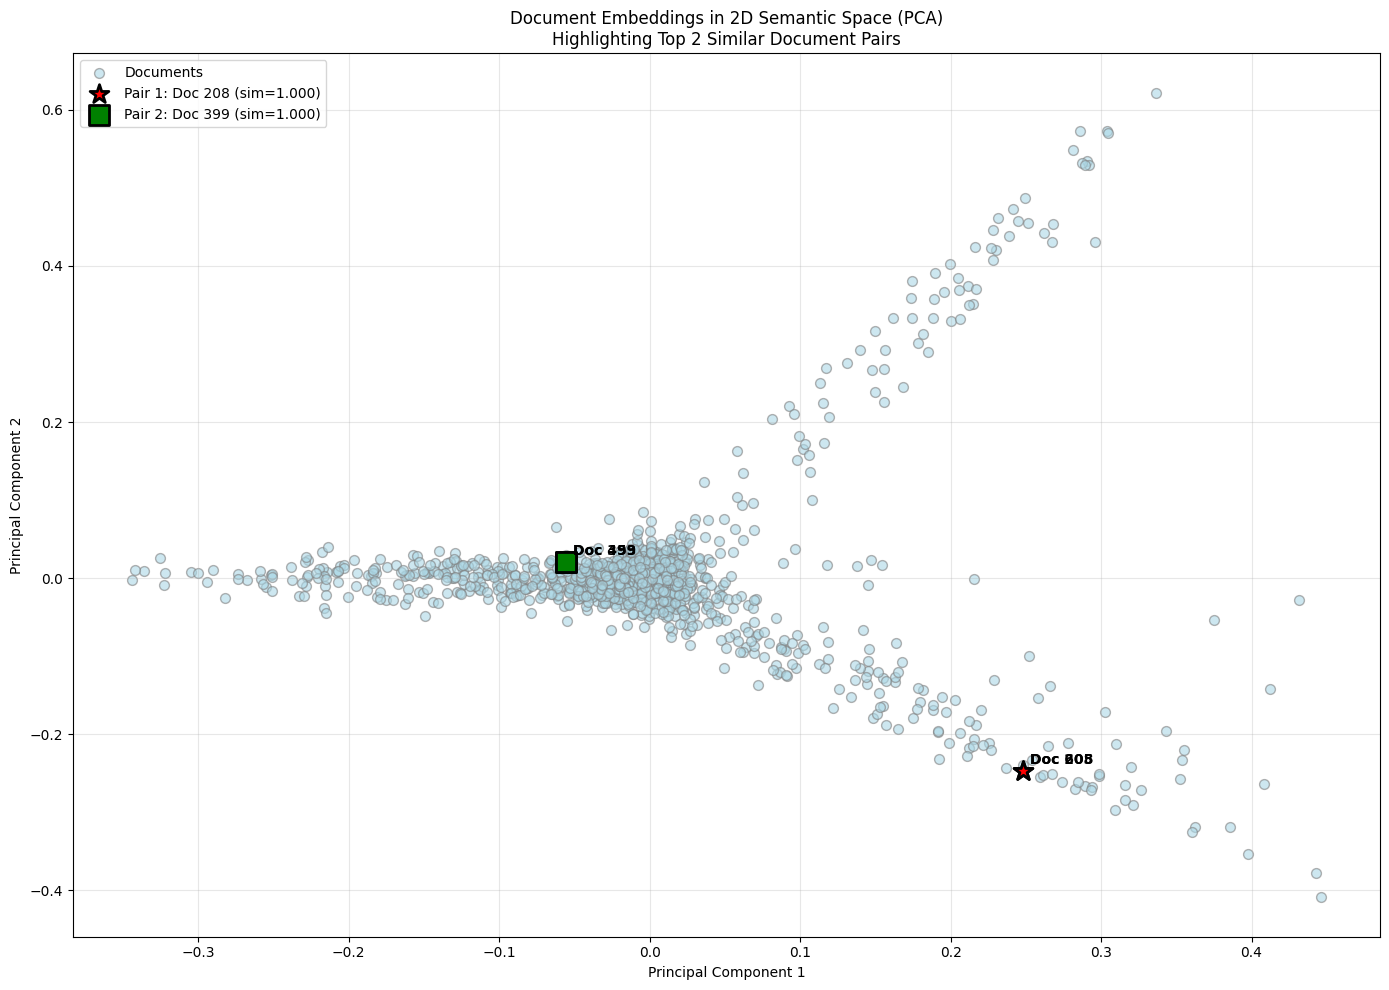

In [23]:
# Visualize all documents in 2D semantic space
plt.figure(figsize=(14, 10))

# Plot all documents
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
            c='lightblue', alpha=0.6, s=50, edgecolors='gray', label='Documents')

# Highlight the top 2 similar pairs
colors = ['red', 'green']
markers = ['*', 's']

for rank, (doc1, doc2, sim_score) in enumerate(top_similar_pairs):
    plt.scatter(embeddings_2d[doc1, 0], embeddings_2d[doc1, 1], 
                c=colors[rank], s=200, marker=markers[rank], edgecolors='black', linewidths=2,
                label=f'Pair {rank+1}: Doc {doc1+1} (sim={sim_score:.3f})')
    plt.scatter(embeddings_2d[doc2, 0], embeddings_2d[doc2, 1], 
                c=colors[rank], s=200, marker=markers[rank], edgecolors='black', linewidths=2)
    
    # Draw line between similar documents
    plt.plot([embeddings_2d[doc1, 0], embeddings_2d[doc2, 0]], 
             [embeddings_2d[doc1, 1], embeddings_2d[doc2, 1]], 
             c=colors[rank], linestyle='--', linewidth=2, alpha=0.7)
    
    # Annotate
    plt.annotate(f'Doc {doc1+1}', (embeddings_2d[doc1, 0], embeddings_2d[doc1, 1]), 
                 xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
    plt.annotate(f'Doc {doc2+1}', (embeddings_2d[doc2, 0], embeddings_2d[doc2, 1]), 
                 xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

plt.xlabel('Principal Component 1', fontsize=10)
plt.ylabel('Principal Component 2', fontsize=10)
plt.title('Document Embeddings in 2D Semantic Space (PCA)\nHighlighting Top 2 Similar Document Pairs', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

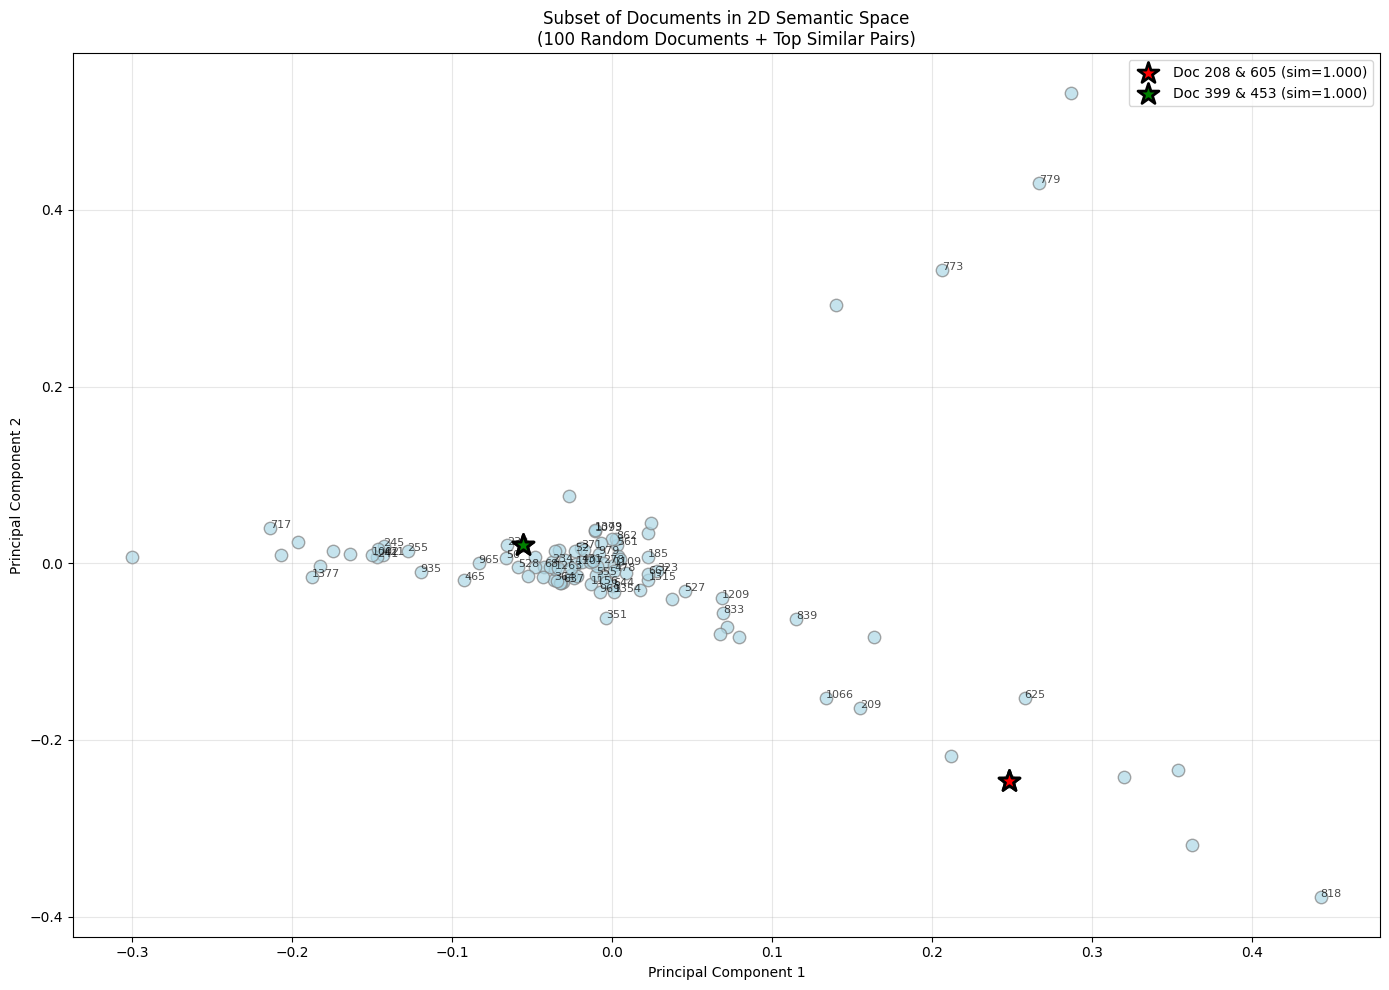

In [24]:
# Select a random subset for clearer visualization
np.random.seed(42)
subset_indices = np.random.choice(len(df), size=100, replace=False)

# Include the top similar pairs in the subset
for doc1, doc2, _ in top_similar_pairs:
    if doc1 not in subset_indices:
        subset_indices = np.append(subset_indices, doc1)
    if doc2 not in subset_indices:
        subset_indices = np.append(subset_indices, doc2)

plt.figure(figsize=(14, 10))

# Plot subset documents
plt.scatter(embeddings_2d[subset_indices, 0], embeddings_2d[subset_indices, 1], 
            c='lightblue', alpha=0.7, s=80, edgecolors='gray')

# Add document labels for subset
for idx in subset_indices[:50]:  # Label first 50 for readability
    plt.annotate(str(idx+1), (embeddings_2d[idx, 0], embeddings_2d[idx, 1]), 
                 fontsize=8, alpha=0.7)

# Highlight top similar pairs
for rank, (doc1, doc2, sim_score) in enumerate(top_similar_pairs):
    plt.scatter(embeddings_2d[doc1, 0], embeddings_2d[doc1, 1], 
                c=colors[rank], s=250, marker='*', edgecolors='black', linewidths=2,
                label=f'Doc {doc1+1} & {doc2+1} (sim={sim_score:.3f})', zorder=5)
    plt.scatter(embeddings_2d[doc2, 0], embeddings_2d[doc2, 1], 
                c=colors[rank], s=250, marker='*', edgecolors='black', linewidths=2, zorder=5)
    plt.plot([embeddings_2d[doc1, 0], embeddings_2d[doc2, 0]], 
             [embeddings_2d[doc1, 1], embeddings_2d[doc2, 1]], 
             c=colors[rank], linestyle='--', linewidth=2, alpha=0.8)

plt.xlabel('Principal Component 1', fontsize=10)
plt.ylabel('Principal Component 2', fontsize=10)
plt.title('Subset of Documents in 2D Semantic Space\n(100 Random Documents + Top Similar Pairs)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

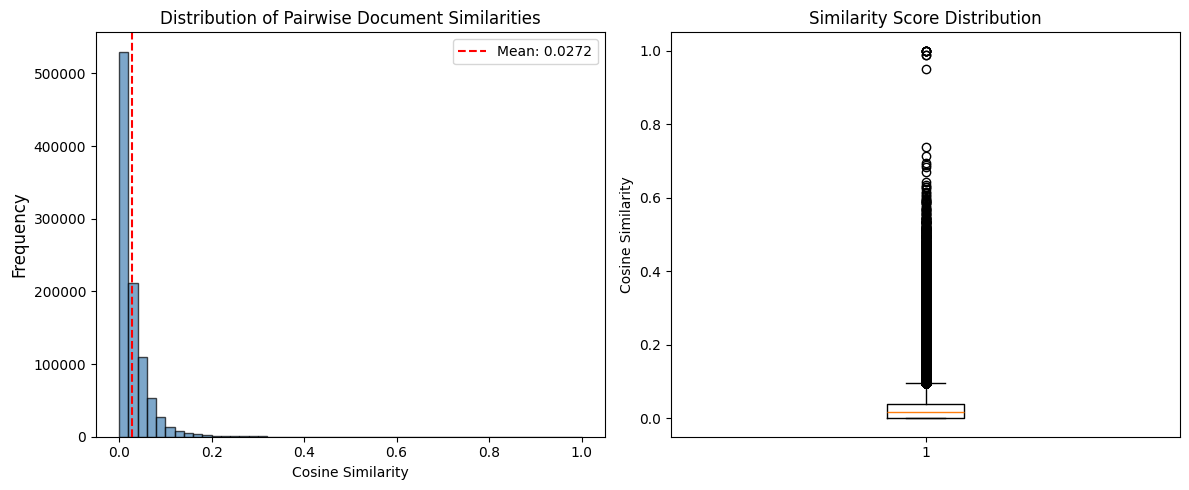


Similarity Statistics:
  Mean: 0.0272
  Std: 0.0375
  Min: 0.0000
  Max: 1.0000
  Median: 0.0169


In [25]:
# Similarity distribution analysis
# Get upper triangle of similarity matrix 
upper_triangle_indices = np.triu_indices(similarity_matrix.shape[0], k=1)
similarities = similarity_matrix[upper_triangle_indices]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(similarities, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Cosine Similarity', fontsize=10)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Pairwise Document Similarities', fontsize=12)
plt.axvline(x=np.mean(similarities), color='red', linestyle='--', label=f'Mean: {np.mean(similarities):.4f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(similarities, vert=True)
plt.ylabel('Cosine Similarity', fontsize=10)
plt.title('Similarity Score Distribution', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nSimilarity Statistics:")
print(f"  Mean: {np.mean(similarities):.4f}")
print(f"  Std: {np.std(similarities):.4f}")
print(f"  Min: {np.min(similarities):.4f}")
print(f"  Max: {np.max(similarities):.4f}")
print(f"  Median: {np.median(similarities):.4f}")

### Part II (iii): Justification

**Choice of Similarity Metric - Cosine Similarity:**

1. **Why Cosine Similarity?**
   - Measures the angle between document vectors, not their magnitude
   - Normalized: Documents of different lengths can be fairly compared
   - Values range from 0 (completely different) to 1 (identical)
   - Standard choice for text similarity in information retrieval

2. **Alternative Metrics Considered:**
   - **Euclidean Distance**: Affected by document length, not suitable for TF-IDF
   - **Jaccard Similarity**: Only considers presence/absence, ignores TF-IDF weights
   - **Manhattan Distance**: Similar issues to Euclidean

**Feature Design Justification (TF-IDF):**
- Captures term importance relative to both document and corpus
- Naturally handles the sparse nature of text data
- Proven effective for document similarity tasks

**PCA for Visualization:**
- Reduces high-dimensional TF-IDF vectors to 2D for plotting
- Preserves maximum variance in the data
- Similar documents cluster together in the reduced space

**Observations from Results:**
- The most similar document pairs share common product-related vocabulary
- The 2D visualization shows natural clustering of similar reviews
- High similarity scores (close to 1.0) indicate reviews discussing similar products or sentiments

---

# Summary

## Part I: N-gram Language Model
- Built a Bigram model trained on 1,394 provided reviews (dataset)
- For "I like _____", the model recommends top 3 words based on bigram frequencies

## Part II: Text Processing & Analysis

### (i) Preprocessing Pipeline
- Tokenization -> Lowercasing -> Stop Word Removal -> Stemming/Lemmatization

### (ii) TF-IDF Feature Extraction
- Created sparse document-term matrix
- Vocabulary size: ~5000 terms
- Captures term importance effectively

### (iii) Similarity Analysis
- Used Cosine Similarity for document comparison
- Identified top 2 most similar document pairs
- Visualized document embeddings in 2D using PCA

---
